<a href="https://colab.research.google.com/github/RiboRings/neurogenomics/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from itertools import combinations
from matplotlib import pyplot as plt

# Part 1 - Normalization of sequencing data

## TMM Normalization

In [52]:
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)

In [ ]:
def TMM_normalization(X, Y, D=0.2):

  idx0 = np.where((X != 0) & (Y != 0))
  X = X[idx0]
  Y = Y[idx0]

  M = np.log(Y / X)
  Wi = np.sqrt((X + Y) / 2)

  lower_quantile = np.quantile(M, D/2)
  upper_quantile = np.quantile(M, 1 - D / 2)

  D2 = np.where((M > lower_quantile) & (M < upper_quantile))
  trimed_m = M[D2]
  trimed_Wi = Wi[D2]

  sorted_idx = np.argsort(trimed_m)
  sorted_m = trimed_m[sorted_idx]
  sorted_w = trimed_Wi[sorted_idx]

  tmm = np.sum(sorted_w * sorted_m) / np.sum(sorted_w)
  factor = np.exp(tmm)
  normalized_Y = Y / factor

  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before TMM normalization")
  axes[0].legend()

  axes[1].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[1].hist(normalized_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after TMM normalization")
  axes[1].legend()

  plt.tight_layout()

  return X, normalized_Y, factor

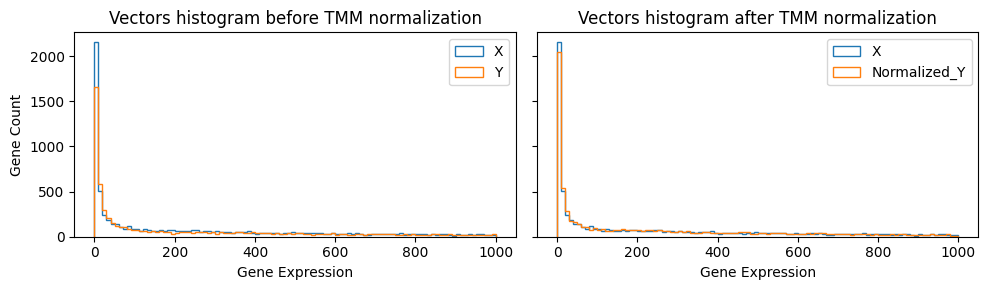

In [ ]:
X = pasilla["untreated1"].to_numpy()
Y = pasilla["untreated2"].to_numpy()

X, norm_Y, factor = TMM_normalization(X, Y)

Quantile normalization

## Part B: Quantile Normalisation

In [ ]:
def quantile_normalisation(X, Y):

  A = np.vstack([X, Y]).T

  order = A.argsort(axis=0)
  ranks = order.argsort(axis=0)

  sorted_A = np.sort(A, axis=0)
  row_mean = np.mean(sorted_A, axis=1)

  norm_A = np.zeros_like(A).astype(float)

  for rank in range(row_mean.size):

    norm_A[ranks == rank] = row_mean[rank]

  norm_X, norm_Y = norm_A[:, 0], norm_A[:, 1]

  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before Quantile normalization")
  axes[0].legend()

  axes[1].hist(norm_X, bins=100, range=[0, 1000], histtype="step", label="Normalized_X")
  axes[1].hist(norm_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after Quantile normalization")
  axes[1].legend()

  plt.tight_layout()

  return norm_X, norm_Y

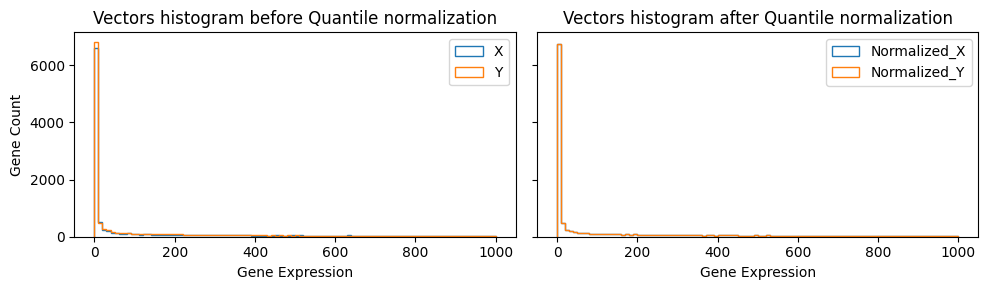

In [ ]:
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)
X = pasilla["untreated1"].to_numpy()
Y = pasilla["treated2"].to_numpy()

norm_X, norm_Y = quantile_normalisation(X, Y)

# Part 2

In [5]:
circ_df = pd.read_csv("CircadianRNAseq.csv")

circ_df.index = circ_df['GeneSymbol'].astype('str').str.cat(circ_df.groupby('GeneSymbol').cumcount().add(1).astype('str'), sep='_')
circ_df = circ_df.drop(columns=["RefSeqID", "GeneSymbol"])
circ_mat = circ_df.to_numpy()

# 1)

In [6]:
def compute_powers(mat):

  powers = fft(mat, axis=1)
  powers = np.abs(powers) ** 2

  powers = powers[:, 1:(1 + powers.shape[1] // 2)]
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)

  circ_powers = norm_powers[:, 1]
  circ_powers = circ_powers[~np.isnan(circ_powers)]
  sorted_powers = np.sort(circ_powers)[::-1]

  return circ_powers

In [22]:
# Define function to compute survivor function of circadian genes
def generate_survivor(powers):

  threshold_range = np.arange(0, 1, 0.01)
  cdf = []

  for threshold in threshold_range:

    genes = np.where(powers >= threshold, 1, 0)
    cdf.append(genes.sum())

  cdf = np.array(cdf)

  return cdf, threshold_range

# Define function to shuffle matrix by axis
def shuffle_along_axis(mat, axis):

  idx = np.random.rand(*mat.shape).argsort(axis=axis)
  shuffled_mat = np.take_along_axis(mat, idx, axis=axis)

  return shuffled_mat

In [32]:
# Compute powers of real matrix
circ_powers = compute_powers(circ_mat)
# Obtain survivor function for real matrix
real_survivor, threshold_range = generate_survivor(circ_powers)

# Shuffle real matrix
shuffled_mat = shuffle_along_axis(circ_mat, axis=0)
# Compute powers of shuffled matrix
shuffled_powers = compute_powers(shuffled_mat)
# Obtain survivor function for shuffled matrix
shuffled_survivor, _ = generate_survivor(shuffled_powers)

<ipython-input-6-47a2753b9b56>:7: RuntimeWarning: invalid value encountered in divide
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)


# 2) + 3)


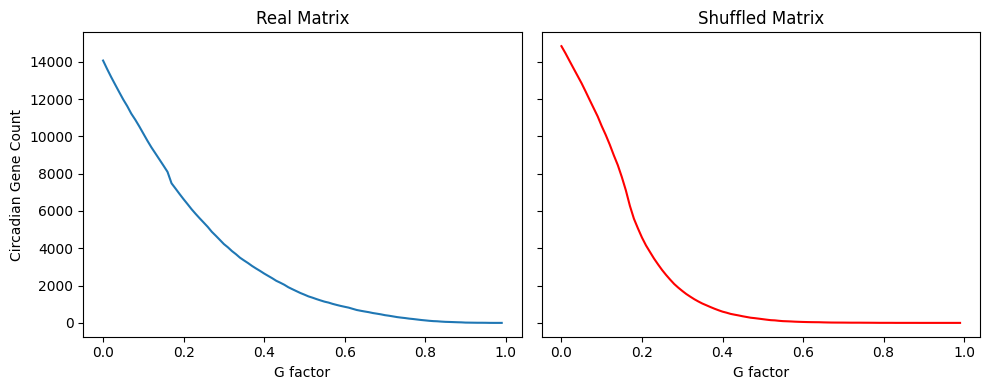

In [36]:
fig, axes = plt.subplots(1, 2, sharey=True)

fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(threshold_range, real_survivor)

axes[0].set_xlabel("G factor")
axes[0].set_ylabel("Circadian Gene Count")
axes[0].set_title("Real Matrix")

axes[1].plot(threshold_range, shuffled_survivor, color = "red")

axes[1].set_xlabel("G factor")
axes[1].set_title("Shuffled Matrix")

plt.tight_layout()

# 4) + 5)

In [38]:
sim = 100
power_list = []

for i in range(sim):

  shuffled_mat = shuffle_along_axis(circ_mat, axis=0)
  shuffled_powers = compute_powers(shuffled_mat)

  power_list.append(shuffled_powers)

power_arr = np.array(power_list)

Text(0, 0.5, 'Circadian Gene Count')

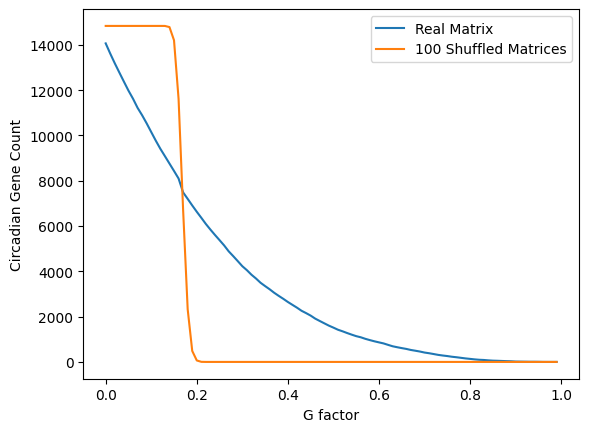

In [42]:
mean_powers = np.mean(power_arr, axis=0)
mean_survivor, _ = generate_survivor(mean_powers)

plt.plot(threshold_range, real_survivor, label = "Real Matrix")
plt.plot(threshold_range, mean_survivor, label = f"{sim} Shuffled Matrices")
plt.legend()

plt.xlabel("G factor")
plt.ylabel("Circadian Gene Count")

# 6) + 7)

<ipython-input-47-b1dda9f62f59>:1: RuntimeWarning: invalid value encountered in divide
  true_positives = (real_survivor - mean_survivor) / real_survivor


Text(0.5, 1.0, 'G factor per amount - True positives')

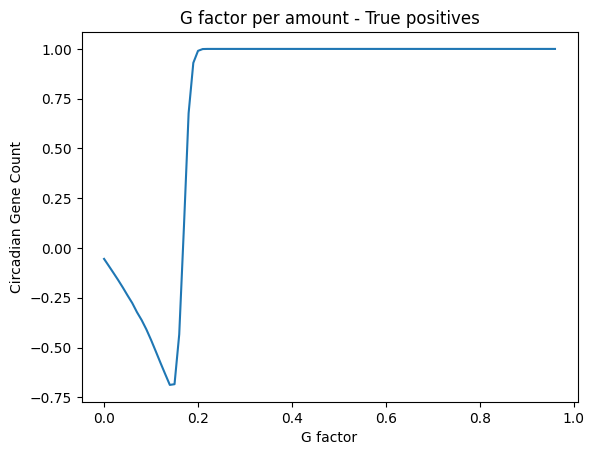

In [47]:
true_positives = (real_survivor - mean_survivor) / real_survivor

plt.plot(threshold_range, true_positives)

plt.xlabel("G factor")
plt.ylabel("Circadian Gene Count")
plt.title("G factor per amount - True positives")

# Part 3: Hierarchical clustering

In [69]:
pas = pasilla.to_numpy()

x = pas[20, :]
y = pas[21, :]

In [100]:
np.corrcoef(pas[0, :], pas[0, :])

array([[1., 1.],
       [1., 1.]])

In [77]:
def compute_pearson(x, y):

  n = x.size

  x_sum = np.sum(x)
  y_sum = np.sum(y)

  r = (n * np.sum(x * y) - x_sum * y_sum) / \
    np.sqrt((n * np.sum(x**2) - x_sum**2) * (n * np.sum(y**2) - y_sum**2))

  return r


def compute_distance(x, y):

  r = compute_pearson(x, y)
  d = 1 - r

  return d

In [113]:
small_pas = pas[:10, :]

D = np.zeros((small_pas.shape[0], small_pas.shape[0]))

diag = np.diag_indices(small_pas.shape[0])
D[diag] = 1

In [124]:
def make_distance_matrix(mat):

  dim = mat.shape[0]

  D = np.zeros((dim, dim))
  diag = np.diag_indices(dim)
  D[diag] = 1

  combos = combinations(range(dim), 2)

  for x, y in combos:

    d = compute_distance(mat[x, :], mat[y, :])

    D[x, y] = d
    D[y, x] = d

  return D

In [128]:
D = make_distance_matrix(small_pas)

array([[1.        , 1.35927755, 1.29310519, 1.42008403, 1.28027657],
       [1.35927755, 1.        , 0.60411005, 0.58877926, 0.04107633],
       [1.29310519, 0.60411005, 1.        , 1.22163186, 0.62658314],
       [1.42008403, 0.58877926, 1.22163186, 1.        , 0.51897075],
       [1.28027657, 0.04107633, 0.62658314, 0.51897075, 1.        ]])